In [74]:
#Je reviens à quelque chose de beaucoup plus simple. On va prouver que l'on obtient le bon FF pour STF classique. 
#Travaillons en mode dense, facile.
# This first version is for the classical STF. 
# Now, try to get to the domain-based STF...

import bempp.api 
import numpy as np
import mtf

from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator

from mtf.utils import bhmie
from mtf.config import config
from mtf.functions import define_bempp_functions
from mtf.assembly.operators import GeneralizedBlockedOperator

from matplotlib import pyplot as plt
from decimal import Decimal
from bempp.api import ZeroBoundaryOperator

bempp.api.enable_console_logging()
M = 3

mtf.config.set_case("B")

tangential_trace, neumann_trace = define_bempp_functions(config)

k0, k1 = config["k_ext"], config["k_int"]
lambda_par, freq = config["lambda"], config["frequency"]

polarization = config["polarization"]
direction = config["direction"]

eps_rel = config["eps_rel"]
mu_rel = config["mu_rel"]
mu0 = config["mu_ext"]
mu1 = mu_rel * mu0

eta_rel = np.sqrt(mu_rel / eps_rel)

print("The exterior wavenumber is: {0}".format(k0))
print("The interior wavenumber is: {0}".format(k1))

print("----")
print("The exterior wavelenght is: {0}".format(lambda_par))
print("The exterior frequency is: {:.2E}".format(Decimal(freq)))

# To do: Go to the multi-domain STF...
if M == 2:
  segments = [[10,20]]
  swapped_normals = [[]]
    
elif M == 3:
  segments = [[10, 12], [20, 12]]
  swapped_normals = [[], [12]]

k_int, k_ext = config["k_int"], config["k_ext"]

n = k_int / k_ext
refIndex = n
numAngles = 901
s1, s2, qext, qsca, qback, gsca = bhmie(k_ext, k_int / k_ext, numAngles)
angles = config['angles']

k_list = []
eta_rel_list = []
mu_list = []

for index in range(M-1):
  k_list.append(k1)
  mu_list.append(mu1)
  eta_rel_list.append(eta_rel)

precision = 1

h = 2 * np.pi/(precision*k0)
grid = bempp.api.shapes.multitrace_sphere(h=1)

print(h, ': h')
print(precision, ': precision')
print(grid.number_of_edges * 2, ': N')


dA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

p1dA = [bempp.api.function_space(grid, "DP", 1, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

rA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
tA = [bempp.api.function_space(grid, "SNC", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

multitrace_ops = []
multitrace_ops0 = []
identity = []
# > Assemble all diagonal operators
for index in range(M-1):
  k = k_list[index]
  mu = mu_list[index]
  eta = eta_rel_list[index]
  efie = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k)
  mfie = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k)
  multitrace_ops.append(GeneralizedBlockedOperator([[mfie, eta * efie],[-1/eta * efie, mfie]]))

  efie0 = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k0)
  mfie0 = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k0)
  multitrace_ops0.append(GeneralizedBlockedOperator([[mfie0, efie0],[-efie0, mfie0]]))

  

# Define the final operator
block_system = [(M-1) * [None] for _ in range(M-1)]

for i in range(M-1):
  for j in range(M-1):
    if i == j:
      block_system[i][j] = (multitrace_ops[i] + multitrace_ops0[i])
    else:
      efie0 = bempp.api.operators.boundary.maxwell.electric_field(dA[j], rA[i], tA[i], k0)
      mfie0 = bempp.api.operators.boundary.maxwell.magnetic_field(dA[j], rA[i], tA[i], k0)
      block_system[i][j]= GeneralizedBlockedOperator([[mfie0, efie0],[-efie0, mfie0]])
            
lhs_op = GeneralizedBlockedOperator(block_system)
op_wf = lhs_op.weak_form()



bempp:HOST:INFO: Created grid with id 67243e7a-d8f0-4a73-9078-384718adfaf0. Elements: 56. Edges: 80. Vertices: 27
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
bempp:HOST:WARNING: Setting include_boundary_dofs has no effect on this space type.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


The exterior wavenumber is: 5.0
The interior wavenumber is: 6.892024376045111
----
The exterior wavelenght is: 1.2566370614359172
The exterior frequency is: 2.39E+8

1.2566370614359172 : h
1 : precision
160 : N


Signature:
bempp.api.operators.boundary.sparse.multitrace_identity(
    multitrace_operator,
    parameters=None,
    device_interface=None,
    precision=None,
)
Docstring:
Create a multitrace identity operator.

Parameters
----------
multitrace_operator : Bempp Operator
    A 2 x 2 multitrace operator object whose spaces are used to define
    the identity operator.

Output
------
A block-diagonal multitrace identity operator.
File:      /usr/local/lib/python3.10/dist-packages/bempp/api/operators/boundary/sparse.py
Type:      function

64.72822501832596

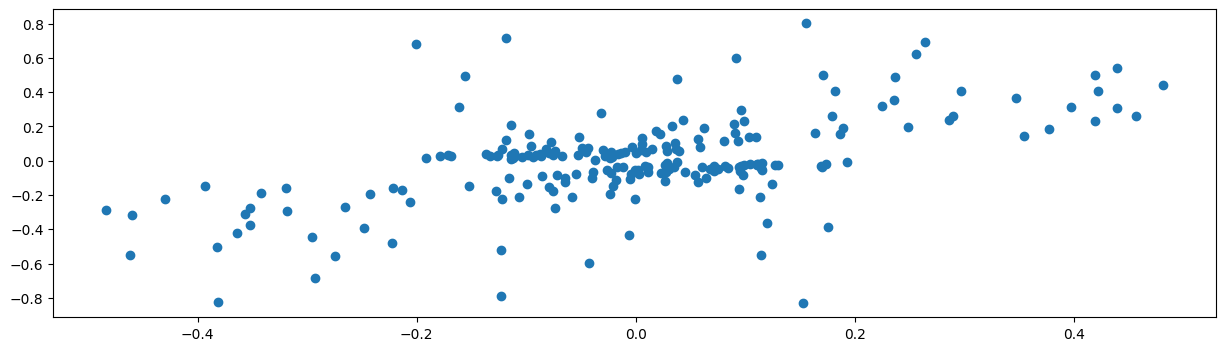

In [67]:
x = np.linalg.eigvals(A)
plt.scatter(x.real,x.imag)
np.linalg.cond(A)

In [70]:
rhs = []
for i in range(M-1):
    temp = [bempp.api.GridFunction(rA[i], dual_space = tA[i], fun=tangential_trace),
      bempp.api.GridFunction(rA[i], dual_space = tA[i], fun=neumann_trace)]

    #my_b = [bempp.api.GridFunction(dA[i], dual_space = rA[i], fun=tangential_trace),
    #   bempp.api.GridFunction(dA[i], dual_space = rA[i], fun=neumann_trace)]

    #temp2 = multitrace_ops0[i] * my_b
    #rhs += [temp[0] + temp2[0], temp[1] + temp2[1]]
    rhs += temp

print(np.linalg.norm(temp2[0].projections()))

0.7026975347181829


In [71]:
b = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(rhs, lhs_op.dual_to_range_spaces)
N = b.shape[0]
A = bempp.api.as_matrix(op_wf)
x = np.linalg.solve(A, b)

sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(x.ravel(), lhs_op.domain_spaces)

In [72]:
print(x.min(), x.max())

(-1.2409280302153594-0.26801432687570353j) (1.213795618106886+0.15505996072837858j)


/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


0.5650289553334371


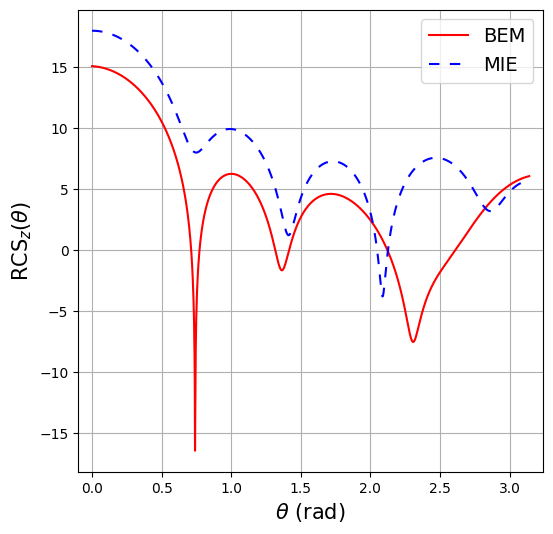

In [73]:
far_field_points = config['far_field_points']

far_field = np.zeros((3, far_field_points.shape[1]), dtype=np.complex128)

for i in range(M-1):
    electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[2*i + 1].space, far_field_points, k0)
    magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[2*i].space, far_field_points, k0)
    far_field +=  - electric_far * sol[2*i+1] - magnetic_far * sol[2*i]
    
A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k_ext) ))
rel_error = np.linalg.norm(uh - u) / np.linalg.norm(u)

print(rel_error)

angles = config['angles']

fig, ax  = plt.subplots(1,1, figsize=(6,6))
plt.rcParams['figure.figsize'] = (15, 4) # Increase the figure size in the notebook

A22 = far_field[2,:]
uh = 10 * np.log10(4 * np.pi * np.abs(A22[:1801]))
u =  10 * np.log10(4 * np.pi * np.abs(s1 / (-1j * k_ext) ))
# -1j * kExt is to make agree with eqn 3.21 p70 tBohren and Huffman

ax.plot(angles[:1801], uh, '-r', label='BEM')
ax.plot(angles[:1801], u, 'b', label='MIE', linestyle=(0, (5, 5)))

ax.set_xlabel(r"$\theta$ (rad)", fontsize=15)
ax.set_ylabel(r"$\mathrm{RCS}_z(\theta)$", fontsize=15)

ymin, ymax = uh.min() - 1, uh.max() + 1
ax.legend(prop={'size': 14})
ax.grid()
plt.xlim(-0.1, np.pi + 0.1)
#plt.ylim(ymin, ymax)
#plt.savefig("plots/RCSSphere.pdf")
plt.show()